In [ ]:
#https://scikit-hts.readthedocs.io/en/latest/readme.html
!pip install scikit-hts

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

import hts

In [2]:
def rmse(true, pred):
    return math.sqrt(mean_squared_error(true, pred))

#### Fonction permettant de calculer la RMSE entre Y_true et pred et Y_true et pred_reconciliation
Calcule également l'effet de la réconciliation sur la RMSE de base

In [3]:
def compute_rmse(true, pred, pred_hier):
    rmse_base = []
    rmse_h = []
    diff = []
    for i, col in enumerate(true.columns):
        rmse_base.append(rmse(true[col], pred[col]))
        rmse_h.append(rmse(true[col], pred_hier[col]))
        diff.append((rmse(true[col], pred_hier[col])-rmse(true[col], pred[col]))/rmse(true[col], pred[col])*100)
    ans = pd.DataFrame({"RMSE Base" : rmse_base, "RMSE Hierachical" : rmse_h, "Diff %" : diff}, index=true.columns)
    return ans

#### Fonction permettant de construire le DataFrame des prédictions

In [4]:
def Construct_Hierachical_Forecast(load):
    hforecast = pd.DataFrame()
    Y_true = pd.DataFrame()
    for i,reg in enumerate(load):
        if reg=="National":
            df = pd.read_csv("https://raw.githubusercontent.com/Tdjaaleb/MALIA/main/Time%20Series/Preprocessing/Data/clean_National.csv", sep=";")
        else:
            df = pd.read_csv(f'https://raw.githubusercontent.com/Tdjaaleb/MALIA/main/Time%20Series/Preprocessing/Data/Region/clean_{reg}.csv', sep=";")

        train = df[:52561]
        val = df[52561:70081]
        covid = df[70081:105216]
        test = df[105216:]

        train = train.dropna()
        Y_train = train["Conso"]
        X_train = train.drop(["Conso","Date","Heure","ConsoT-1"], axis=1)

        Y_test = test["Conso"]
        Y_test = Y_test.reset_index().drop(["index"], axis=1)
        X_test = test.drop(["Conso","Date","Heure","ConsoT-1"], axis=1)

        if reg!="National":
            X_train = X_train.drop(["Temperature"], axis=1)
            X_test = X_test.drop(["Temperature"], axis=1)

        model = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=100)
        model.fit(X_train, Y_train)
        pred = model.predict(X_test)
        if reg=="National":
            hforecast["total"] = pred
            Y_true["total"] = Y_test
        else:
            hforecast[f'{reg}'] = pred
            Y_true[f'{reg}'] = Y_test
    return hforecast, Y_true

In [5]:
to_load = ["National", "Aura", "Bourgogne", "Bretagne", "Centre", "GrandEst", "HautsDeFrance", "IDF", "Normandie", "NouvelleAquitaine", "Occitanie", "PACA", "PaysDeLoire"]
hier = {'total': ["Aura", "Bourgogne", "Bretagne", "Centre", "GrandEst", "HautsDeFrance", "IDF", "Normandie", "NouvelleAquitaine", "Occitanie", "PACA", "PaysDeLoire"]}
hforecast, Y_true = Construct_Hierachical_Forecast(to_load)

In [6]:
#Valeurs réelles
Y_true.head(3)

,total,Aura,Bourgogne,Bretagne,Centre,GrandEst,HautsDeFrance,IDF,Normandie,NouvelleAquitaine,Occitanie,PACA,PaysDeLoire
0,54578.0,7790.0,2335.0,2923.0,2314.0,4524.0,5278.0,7639.0,3106.0,5233.0,4967.0,5313.0,3157.0
1,54083.0,7721.0,2282.0,2848.0,2260.0,4493.0,5250.0,7600.0,3053.0,5313.0,4947.0,5160.0,3157.0
2,52169.0,7514.0,2227.0,2637.0,2180.0,4359.0,5096.0,7326.0,2956.0,5172.0,4731.0,4980.0,2990.0


In [7]:
#Valeurs prédites indépendemment
hforecast.head(3)

,total,Aura,Bourgogne,Bretagne,Centre,GrandEst,HautsDeFrance,IDF,Normandie,NouvelleAquitaine,Occitanie,PACA,PaysDeLoire
0,54446.212595,7807.438751,2232.623387,3005.887856,2443.803520,4515.436972,5479.706745,7707.697533,3233.996878,5311.805644,4668.715477,5331.212324,3187.758904
1,53046.210992,7669.702927,2256.105333,2913.679947,2404.651364,4404.242897,5413.662217,7579.055734,3162.867475,5319.144173,4486.301947,5103.773892,3158.377051
2,50894.551563,7653.176773,2199.088810,2702.428232,2314.163857,4318.446543,5227.053768,7218.618426,2959.746568,5011.833573,4301.214466,4866.516207,2934.206507


In [8]:
tree = hts.hierarchy.HierarchyTree.from_nodes(hier, hforecast)
sum_mat, sum_mat_labels = hts.functions.to_sum_mat(tree)
pred_dict = collections.OrderedDict()
for label in sum_mat_labels:
        pred_dict[label] = pd.DataFrame(data=hforecast[label].values, columns=['yhat'])

## Réconciliation

#### Ordinary Least Squares Method

In [18]:
revised = hts.functions.optimal_combination(pred_dict, sum_mat, method='OLS', mse={})
revised_forecasts = pd.DataFrame(data=revised[0:,0:],
                                    index=hforecast.index,
                                    columns=sum_mat_labels)
#Valeurs réconciliées avec la méthode OLS
revised_forecasts.head(3)

,total,Aura,Bourgogne,Bretagne,Centre,GrandEst,HautsDeFrance,IDF,Normandie,NouvelleAquitaine,Occitanie,PACA,PaysDeLoire
0,54483.125779,7770.525567,2195.710203,2968.974671,2406.890335,4478.523788,5442.793560,7670.784349,3197.083693,5274.892460,4631.802293,5294.299139,3150.845719
1,53109.699759,7606.214160,2192.616567,2850.191180,2341.162598,4340.754131,5350.173450,7515.566968,3099.378708,5255.655407,4422.813180,5040.285126,3094.888284
2,50957.008653,7590.719684,2136.631720,2639.971142,2251.706767,4255.989453,5164.596678,7156.161336,2897.289478,4949.376483,4238.757376,4804.059118,2871.749418


In [19]:
results = compute_rmse(Y_true, hforecast, revised_forecasts)
results

,RMSE Base,RMSE Hierachical,Diff %
total,2150.534873,2136.964674,-0.631015
Aura,391.323571,395.419351,1.046648
Bourgogne,153.562876,168.553620,9.761958
Bretagne,212.171041,221.630179,4.458261
Centre,171.169205,181.053007,5.774288
GrandEst,304.894344,305.452389,0.183029
HautsDeFrance,455.460318,448.789716,-1.464585
IDF,475.010654,476.874165,0.392309
Normandie,176.473804,188.594954,6.868526
NouvelleAquitaine,410.782972,407.643969,-0.764151


In [20]:
#Variation moyenne de la RMSE après réconciliation
print(results["Diff %"].mean(), "%")

2.522350995580916 %


#### Structurally Weighted Least Squares

In [12]:
revised = hts.functions.optimal_combination(pred_dict, sum_mat, method='WLSS', mse={})
revised_forecasts = pd.DataFrame(data=revised[0:,0:],
                                    index=hforecast.index,
                                    columns=sum_mat_labels)
#Valeurs réconciliées avec la méthode WLSS
revised_forecasts.head(3)

,total,Aura,Bourgogne,Bretagne,Centre,GrandEst,HautsDeFrance,IDF,Normandie,NouvelleAquitaine,Occitanie,PACA,PaysDeLoire
0,54686.148293,7787.444110,2212.628746,2985.893214,2423.808878,4495.442331,5459.712103,7687.702892,3214.002236,5291.811003,4648.720836,5311.217682,3167.764262
1,53458.887975,7635.313178,2221.715585,2879.290198,2370.261616,4369.853149,5379.272468,7544.665986,3128.477726,5284.754425,4451.912198,5069.384144,3123.987302
2,51300.522646,7619.345850,2165.257886,2668.597308,2280.332933,4284.615620,5193.222844,7184.787502,2925.915644,4978.002649,4267.383542,4832.685284,2900.375584


In [13]:
results = compute_rmse(Y_true, hforecast, revised_forecasts)
results

,RMSE Base,RMSE Hierachical,Diff %
total,2150.534873,2100.894000,-2.308304
Aura,391.323571,392.069982,0.190740
Bourgogne,153.562876,158.229091,3.038635
Bretagne,212.171041,214.659090,1.172662
Centre,171.169205,173.274074,1.229701
GrandEst,304.894344,303.289235,-0.526448
HautsDeFrance,455.460318,450.573116,-1.073025
IDF,475.010654,474.800234,-0.044298
Normandie,176.473804,179.942252,1.965418
NouvelleAquitaine,410.782972,407.664557,-0.759139


In [17]:
#Variation moyenne de la RMSE après réconciliation
print(results["Diff %"].mean(), "%")

0.2919185839453849 %


La méthode WLSS semble être meilleure pour réconcilier nos prédictions. A noter que l'effet de la réconciliation est dépendant de notre modèle de base, malgré cela, après plusieurs essais, la méthode WLSS à toujours eu de meilleurs résultats.

#### Comparaison des différentes prédictions sur la consommation Nationale

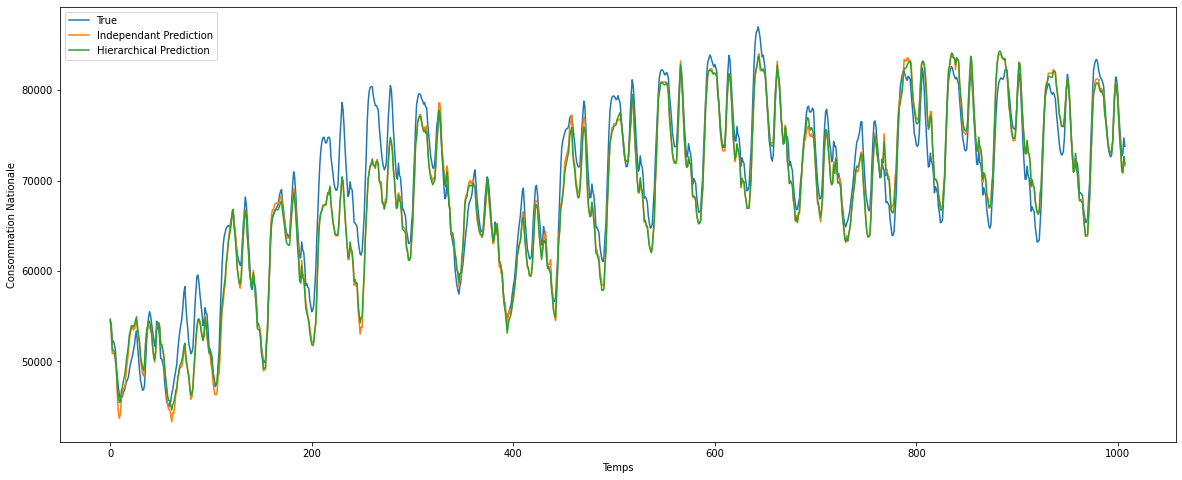

In [15]:
plt.figure(figsize=(20,8))
plt.plot(Y_true["total"][0:1008])
plt.plot(hforecast['total'][0:1008])
plt.plot(revised_forecasts["total"][0:1008])

plt.legend(["True", "Independant Prediction", "Hierarchical Prediction"])
plt.xlabel("Temps")
plt.ylabel("Consommation Nationale")
plt.show()

#### Observation de la réconciliation

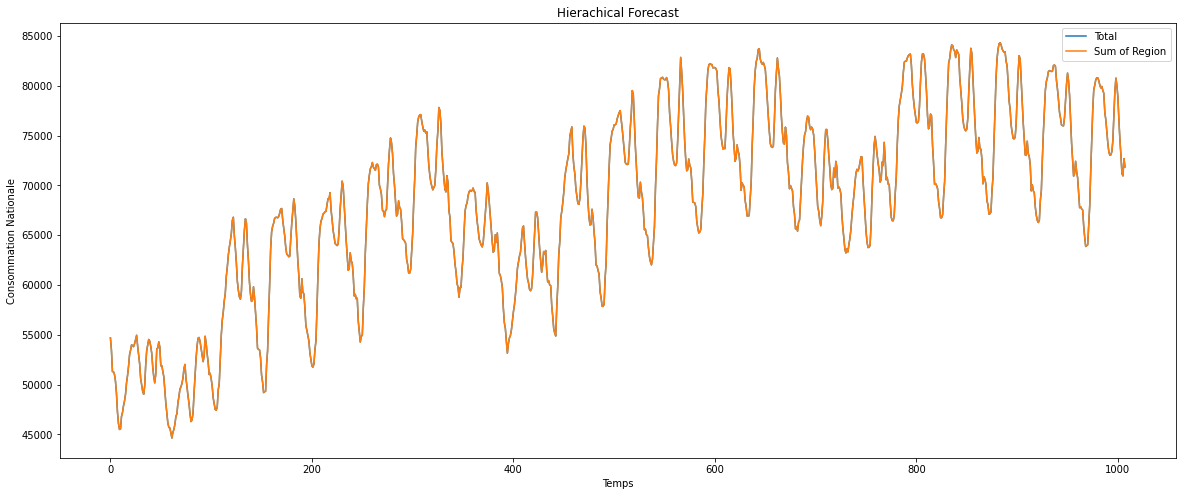

In [16]:
plt.figure(figsize=(20,8))
plt.plot(revised_forecasts["total"][0:1008])
plt.plot(revised_forecasts.drop(["total"], axis=1).sum(axis=1)[0:1008])
plt.legend(["Total", "Sum of Region"])
plt.title("Hierachical Forecast")
plt.xlabel("Temps")
plt.ylabel("Consommation Nationale")
plt.show()

La réconciliation est bien respectée, la somme des consommations par région prédites est égale à la consommation nationale prédite.